In [222]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import scipy.misc
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import math

# Import everything needed to edit/save/watch video clips
from IPython.display import HTML
from moviepy.editor import VideoFileClip

In [223]:
class CarDetector:
# spatial_size = (16, 16) # Spatial binning dimensions
# hist_bins = 16    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off

    def __init__(self, cspace='YUV', spatial_size=(32, 32),
                 hist_bins=32, hist_range=(0, 256), orient=9, 
                 pix_per_cell=8, cell_per_block=2, hog_channel=1, 
                 spatial=False, histogram=True, hog=True):
        
        self.cspace =cspace
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.hist_range=hist_range
        self.orient = orient
        self.pix_per_cell=pix_per_cell
        self.cell_per_block=cell_per_block
        self.hog_channel=hog_channel
        self.vis=False
        self.feature_vec=True
        self.spatial=spatial
        self.histogram=histogram
        self.hog=hog
        self.classifier = []
        self.scaler = []
        
    def get_classifier(self):
        return self.classifier
    
    def get_scaler(self):
        return self.scaler

    def train_classifier(self,cars,notcars):
        classifier_file = 'classifier.pkl'
        scaler_file = 'scaler.pkl'
        # extract features from dataset
        car_features = car_detector.extract_features(cars)
        print("Car features extracted")
        notcar_features = car_detector.extract_features(notcars)
        print("Other features extracted")# Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        print("X_scaler ready")
        #save the model
        joblib.dump(X_scaler, scaler_file)
        # Apply the scaler to X - normalise data
        scaled_X = X_scaler.transform(X)
        print("Data normalised")
        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        print(t2-t, 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Train Accuracy of SVC = ', svc.score(X_train, y_train))
        print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
        # Check the prediction time for a single sample
        t=time.time()
        prediction = svc.predict(X_test[0].reshape(1, -1))
        print("prediction",prediction)
        t2 = time.time()
        print(t2-t, 'Seconds to predict with SVC')
        print(svc)
        # save the model
        joblib.dump(svc, classifier_file)
        self.classifier = svc
        self.scaler = X_scaler
        print("Model saved as:",classifier_file," and ", scaler_file)
    
    def load_classifier(self,classifier_file,scaler_file):
        self.classifier = joblib.load(classifier_file)
        self.scaler = joblib.load(scaler_file)
        print("Model loaded: \n\n",self.classifier)
    
    # Define a function to compute binned color features  
    def bin_spatial(self, img):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img,self.spatial_size).ravel() 
        # Return the feature vector
        return features
    
    # Define a function to compute color histogram features  
    def color_hist(self,img):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=self.hist_bins, range=self.hist_range)
        channel2_hist = np.histogram(img[:,:,1], bins=self.hist_bins, range=self.hist_range)
        channel3_hist = np.histogram(img[:,:,2], bins=self.hist_bins, range=self.hist_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    # Define a function to return HOG features and visualization
    def get_hog_features(self,img_channel):
        
        # Call with two outputs if vis==True
        if self.vis == True:
            features, hog_image = hog(img_channel, orientations=self.orient, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                      cells_per_block=(self.cell_per_block, self.cell_per_block), transform_sqrt=True, 
                                      visualise=self.vis, feature_vector=self.feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img_channel, orientations=self.orient, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                           cells_per_block=(self.cell_per_block, self.cell_per_block), transform_sqrt=True, 
                           visualise=self.vis, feature_vector=self.feature_vec)
            return features

    def extract_features_img(self, rgb_img):
    # apply color conversion if other than 'RGB'
        features=[]
        if self.cspace != 'RGB':
            if self.cspace == 'HSV':
                feature_image = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
            elif self.cspace == 'LUV':
                feature_image = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2LUV)
            elif self.cspace == 'HLS':
                feature_image = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
            elif self.cspace == 'YUV':
                feature_image = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)
            elif self.cspace == 'YCrCb':
                feature_image = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YCrCb)
        else: 
    #             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to rgb
                feature_image = np.copy(rgb_img)
        # Apply bin_spatial() to get spatial color features
        if self.spatial:
            features.append(self.bin_spatial(rgb_img)) # extract spatial only in RGB
#             features.append(self.bin_spatial(feature_image))
        # Apply color_hist() also with a color space option now
        if self.histogram:
            features.append(self.color_hist(feature_image))
        if self.hog:
            if self.hog_channel=='ALL':
                features.append(self.get_hog_features(feature_image[:,:,0]))
                features.append(self.get_hog_features(feature_image[:,:,1]))
#                 features.append(self.get_hog_features(feature_image[:,:,2]))
            else:
                features.append(self.get_hog_features(feature_image[:,:,self.hog_channel]))
#         gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
#         hog_features = self.get_hog_features(gray_img)
        # Append the new feature vector to the features list
#         features= np.concatenate((spatial_features, hist_features, hog_features))#,hog_features_1, hog_features_2))
        features= np.concatenate((features))
        return features
            
    # Define a function to extract features from a list of images
    # Have this function call bin_spatial() and color_hist()
    # this function combines color, histogram and hog features extraction
    def extract_features(self,img_files):
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for file in img_files:
            # Read in each one by one
#             rgb_img = mpimg.imread(file)
            rgb_img = scipy.misc.imread(file)
    #         image = cv2.imread(file) # reads a file into bgr values 0-255
            features.append(self.extract_features_img(rgb_img))
        
        # Return list of feature vectors
        return features

In [136]:
def load_dataset():
    cars = []
    notcars = []

    # load vehicle images
    images = glob.iglob('vehicles/*/*.png', recursive=True)
    for image in images:
        cars.append(image)

    # load non vehicle images
    images = glob.iglob('non-vehicles/*/*.png', recursive=True)
    for image in images:
        notcars.append(image)

    print('cars = ',len(cars))
    print('notcars = ',len(notcars))
    return cars,notcars

def peak_data(cars, notcars):
    data_info = data_look(cars, notcars)
    print('Your function returned a count of', 
          data_info["n_cars"], ' cars and', 
          data_info["n_notcars"], ' non-cars')
    print('of size: ',data_info["image_shape"], ' and data type:', 
          data_info["data_type"])
    # Just for fun choose random car / not-car indices and plot example images   
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))

    # Read in car / not-car images
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_image)
    plt.title('Example Not-car Image')
    plt.show()

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict


# Method
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


# Train or Load existing Model 
# ========================

cars =  8792
notcars =  8968
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


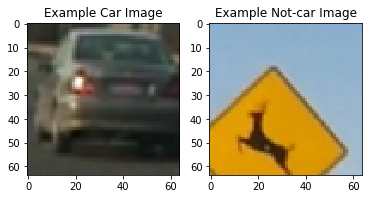

Car features extracted
Other features extracted
X_scaler ready
Data normalised
10.805987358093262 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.989301801802
prediction [ 1.]
0.0008614063262939453 Seconds to predict with SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Model saved as: classifier.pkl  and  scaler.pkl


In [137]:
new_model = False
new_model = True

# create a CarDetector object
car_detector = CarDetector(cspace='HSV',hog_channel=2,spatial=True,histogram=True,hog=True)
#cspace='RGB', spatial_size=(16, 16),hist_bins=16,hog_channel=0) #cspace='YUV',hog_channel=1) # Options: RGB, HSV, LUV, HLS, YUV 
        
if (new_model):
    # load the dataset
    cars,notcars = load_dataset()
    peak_data(cars,notcars)
    #train the classifier
    car_detector.train_classifier(cars,notcars)
else:
    # load existing model
    car_detector = CarDetector()
    car_detector.load_classifier('classifier.pkl','scaler.pkl')

# Sliding Window Implementation

In [138]:

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5),max_y=780):
    height, width, channels = img.shape
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = int(xs*nx_pix_per_step + x_start_stop[0])
            endx = int(startx + xy_window[0])
            starty = int(ys*ny_pix_per_step + y_start_stop[0])
            endy = int(starty + xy_window[1])
            # Append window position to list
            if endy<height and endx < width and endy<max_y:
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
    
# create a list of rectangles with different sizes across the lower part of the image for searching cars
def create_list_rectangles(img):

    height, width, channels = img.shape
    window_list=();
    rectangles = []

    step_h = 32
    start_h = step_h#int(height/4)
    stop_h = height 
    size_of_sq = int(256 * (1/height))
    y_val = int(9*height/16) 

#     size_vec = [64, 96, 128, 160]
#     overlap_vec = [0, 0.5, 0.65, 0.8]
    size_vec = [100, 140]
    overlap_vec = [0.5, 0.5]
#     size_vec = [96, 128, 160, 192]
#     overlap_vec = [0.5, 0.5, 0.5, 0.5]
    for i in range(len(size_vec)):
        size = size_vec[i]
        overlap = overlap_vec[i]
        window_list = slide_window(img, x_start_stop=[0, width+size], y_start_stop=[y_val,y_val+4*size], 
                        xy_window=(size, size), xy_overlap=(overlap,overlap),max_y=height*0.9)
        rectangles.extend(window_list)
    return rectangles

In [139]:
def draw_rectangles(img,window_list,color= (255,255,255)):
    labeled_img = img.copy()
    for window in window_list:
        pt1 = window[0]
        pt2 = window[1]
        thickness = 4
        cv2.rectangle(labeled_img, pt1, pt2, color, thickness)
    return labeled_img

In [242]:
# Create the heat map
def get_heat_map(img,rectangles,car_detector,heat_increment=25):
    
    CV_FILLED = -1
    heat_map = np.zeros_like(img)
    
    for rectangle in rectangles:
        heat_img = np.zeros_like(img)
        pt1 = rectangle[0]
        pt2 = rectangle[1]
        crop_img = img[pt1[1]:pt2[1], pt1[0]:pt2[0]]
        size = (64,64)
        crop_img = cv2.resize(crop_img, size)#.astype(np.float64)
        
        img_features = car_detector.extract_features_img(crop_img)

        features = np.vstack((img_features)).astype(np.float64)
        features = np.array(features).reshape(1, -1)
        
        feature_scaler = car_detector.get_scaler()
        classifier = car_detector.get_classifier()
        
        scaled_features = feature_scaler.transform(features)
        prediction = classifier.predict(scaled_features.reshape(1, -1))
        
        if prediction == 1:
            cv2.rectangle(heat_img, pt1, pt2, color=(heat_increment,heat_increment,heat_increment), thickness=CV_FILLED)
            heat_map = cv2.add(heat_map, heat_img)
            
    return heat_map

In [243]:
# apply filter to the heat_map
# Note: th_ratio should be a ratio (0-1)
# It will be used with respect to the maximum pixel value in the image
def filter_heat_map(heat_map, th_ratio=0.5):
    red_channel = np.copy(heat_map[:,:,0])
#     print("max:",np.amax(red_channel))
    th = np.amax(red_channel)*th_ratio # define threshold
#     print("th:",th)
    filt_heat_map = np.zeros_like(heat_map)
    if np.amax(red_channel)>0:
        red_channel[red_channel>=th]=255
        red_channel[red_channel<th]=0
        filt_heat_map[:,:,0]=red_channel
    return filt_heat_map

In [268]:
# computes positions and bounding rectangles identifying the location of detected vehicles
def get_detected(heat_map,area_th = 20,heat_th=80):
     # define a threshold for minimum area required to be a positive detection
    imgray = heat_map[:,:,0]#cv2.cvtColor(heat_map,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray.astype(np.uint8),heat_th,255,cv2.THRESH_BINARY) #60
    
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#     im2, contours, hierarchy = cv2.findContours(heat_map[:,:,0],cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    data = []
    for contour in contours:
        area = cv2.contourArea(contour)
#         print(area)
        if area>area_th:
            x,y,w,h = cv2.boundingRect(contour)
            M = cv2.moments(contour)
            # calculate image centroid
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            pt1 = (x,y)
            pt2 = (x+w,y+h)
            coord = [cx,cy]
            rect = [pt1,pt2]
            data.append((coord,rect,area))
    return data

In [269]:
def get_distance(pt1, pt2):
    return math.sqrt((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2)

In [270]:
def filter_by_location(data, valid_data, th=50):
#     for each element of data, chech if there is one in filter data that is close enough
#     if so, then it is a valid element
    posit_data = []
    for elem in data:
        for valid_el in valid_data:
            #compute distance
            distance = get_distance(elem[0],valid_el[0])
            if distance<th:
                posit_data.append(elem)
    return posit_data

In [271]:
def create_map_from_data(img,posit_data,heat_increment=25):
    new_heat_map = np.zeros_like(img) # 1 channel is enough
    for elem in posit_data:
        cv2.rectangle(new_heat_map,elem[1][0],elem[1][1],(heat_increment,heat_increment,heat_increment),thickness=-1) #filled rect
    return new_heat_map

In [307]:
def process_image(img,debug=0):
    heat_increment = 25 #25
    heat_thres=80
    if not hasattr(process_image, "heat_map_old"):
        process_image.heat_map_old = np.zeros_like(img)
    
    if not process_image.heat_map_old.size:
        process_image.heat_map_old = np.zeros_like(img)
    
    decay = 0.05
    # apply decay to the heat_map
    process_image.heat_map_old = process_image.heat_map_old*(1-decay)

    #get heat_map
    heat_map = get_heat_map(img,process_image.rectangles,process_image.car_detector,heat_increment)
    
    #filter the heat map to get rid of false positives
    filtered_heat_map = filter_heat_map(heat_map,th_ratio=0.5)
    valid_data = get_detected(filtered_heat_map,area_th = 1000,heat_th=heat_thres)
    # now that we know the location of valid positives
    # we can use the original heat map to get the complete area and filter out false positives
    filtered_heat_map = filter_heat_map(heat_map,th_ratio=0.05)
    data = get_detected(filtered_heat_map,area_th = 1000,heat_th=heat_thres)
    posit_data = filter_by_location(data, valid_data)
    
    # now we create a new filtered_heat_map with the posit_data only
    filtered_heat_map = create_map_from_data(img,posit_data,heat_increment=255)
    
    process_image.heat_map_old = (filtered_heat_map*0.2 + process_image.heat_map_old*0.8)
#     process_image.heat_map_old = (heat_map + process_image.heat_map_old)
    
    final_data = get_detected(process_image.heat_map_old, area_th=1000, heat_th=100)
    
    detected_car_rectangles = []
    for elem in final_data:
        detected_car_rectangles.append(elem[1])
    
    detected_cars_img = draw_rectangles(img,detected_car_rectangles,color= (255,255,255))
    
    if debug:
        # Ploting images
        labeled_img = draw_rectangles(img,process_image.rectangles)

        fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 9))
        fig.tight_layout();
        

        ax1.imshow(heat_map)
        ax1.set_title('Heat map')
        ax2.imshow(filtered_heat_map.astype(np.uint8))
        ax2.set_title('Filtered heat_map')
        ax3.imshow(process_image.heat_map_old.astype(np.uint8))
        ax3.set_title('Used heat_map')
        ax4.imshow(img)
        ax4.set_title('Source image')
        ax5.imshow(labeled_img)
        ax5.set_title('Positive cars')
        ax6.imshow(detected_cars_img)
        ax6.set_title('Confirmed cars')
        ax1.axis('off');
        ax2.axis('off');
        ax3.axis('off');
        ax4.axis('off');
        ax5.axis('off');
        ax6.axis('off');
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.);
        plt.show();
        
    return detected_cars_img

In [308]:
#reset heat_map_old
process_image.heat_map_old=np.zeros_like(rgb_img)
process_image.car_detector = car_detector
process_image.rectangles = create_list_rectangles(rgb_img)

In [321]:
# file = 'test_images/test_14.png' # two cars, black and white
# file = 'test_images/test_13.png' # two cars, black and white
# file = 'test_images/test_12.png' # two cars, black and white
# file = 'test_images/test_11.png' # two cars, black and white
# file = 'test_images/test_10.png' # two cars, black and white
# file = 'test_images/test_09.png' # two cars, black and white
# file = 'test_images/test_08.png' # two cars, black and white
# file = 'test_images/test_07.png' # two cars, black and white
file = 'test_images/test_06.jpg' # two cars, black and white
# file = 'test_images/test_05.jpg' # two cars, black and white
# file = 'test_images/test_04.jpg' # two cars, black and white
# file = 'test_images/test_03.jpg' # white car
# file = 'test_images/test_02.jpg' # no cars
# file = 'test_images/test_01.jpg' # two cars, black and white

# file = 'seq_img/test_01.png'
# file = 'seq_img/test_02.png'
# file = 'seq_img/test_03.png'
# file = 'seq_img/test_04.png'
# file = 'seq_img/test_05.png'
# file = 'seq_img/test_06.png'
# file = 'seq_img/test_07.png'
# file = 'seq_img/test_08.png'
# file = 'seq_img/test_09.png'
# file = 'seq_img/test_10.png'
# file = 'seq_img/test_11.png'
# file = 'seq_img/test_12.png'
# file = 'seq_img/test_13.png'
# file = 'seq_img/test_14.png'
# file = 'seq_img/test_15.png'
# file = 'seq_img/test_16.png'
# file = 'seq_img/test_17.png'
# file = 'seq_img/test_18.png'
# file = 'seq_img/test_19.png'
# file = 'seq_img/test_20.png'
# file = 'seq_img/test_21.png'
# file = 'seq_img/test_22.png'
# file = 'seq_img/test_23.png'
# file = 'seq_img/test_24.png'
# file = 'seq_img/test_25.png'
# file = 'seq_img/test_26.png'
# file = 'seq_img/test_27.png'
file = 'seq_img/test_28.png'
file = 'seq_img/test_29.png'
file = 'seq_img/test_30.png'
file = 'seq_img/test_31.png'
file = 'seq_img/test_32.png'
file = 'seq_img/test_33.png'
file = 'seq_img/test_34.png'
file = 'seq_img/test_35.png'
# file = 'seq_img/test_36.png'
# file = 'seq_img/test_37.png'
# file = 'seq_img/test_38.png'
# file = 'seq_img/test_39.png'
# file = 'seq_img/test_40.png'
# file = 'seq_img/test_41.png'


rgb_img = scipy.misc.imread(file)
# rgb_img = mpimg.imread(file)

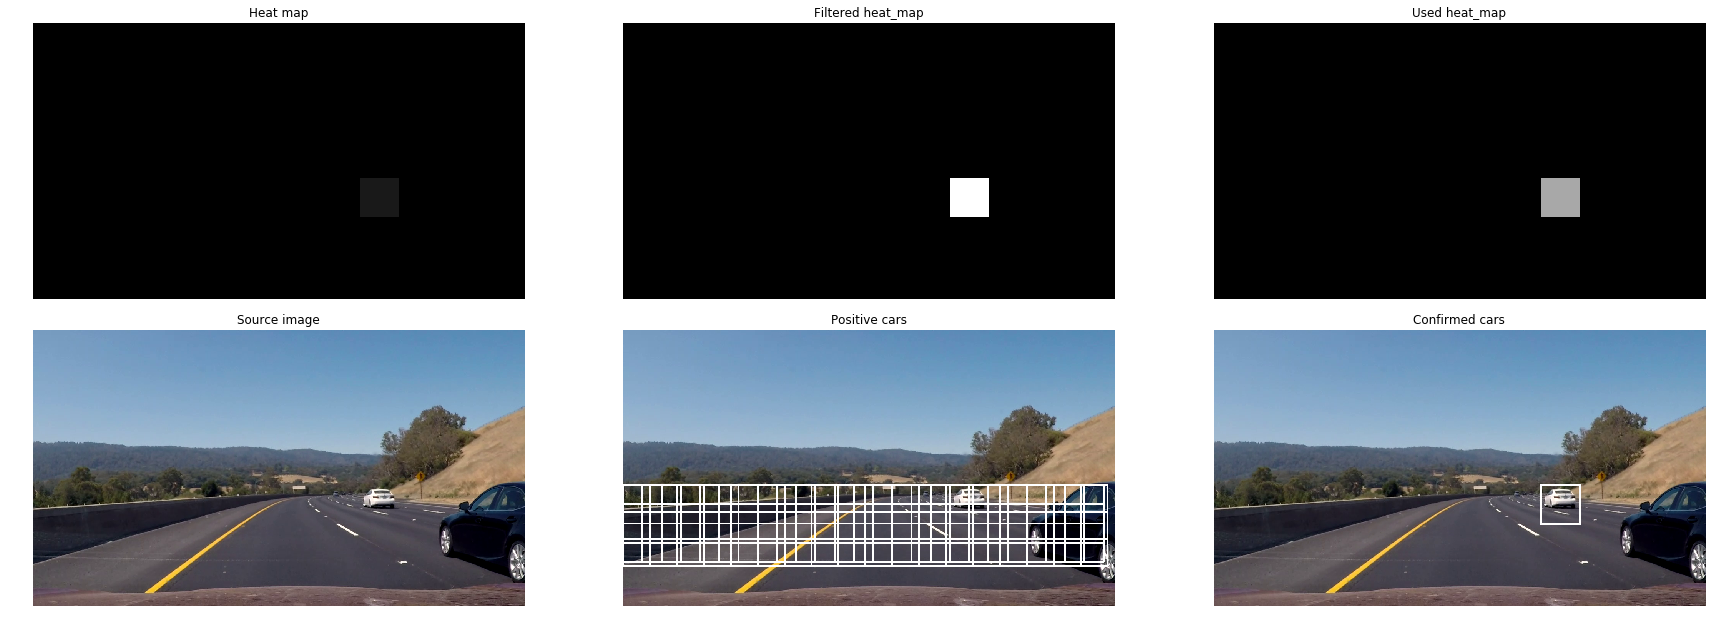

In [322]:
process_image(rgb_img,debug=1);

In [323]:
#reset heat_map_old
process_image.heat_map_old=np.zeros_like(rgb_img)
process_image.car_detector = car_detector
process_image.rectangles = create_list_rectangles(rgb_img)

video_output = 'output_images/test_output.mp4';
clip1 = VideoFileClip("test_video.mp4");
video_clip = clip1.fl_image(process_image); #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False);
print('Finished processing video file')

[MoviePy] >>>> Building video output_images/test_output.mp4
[MoviePy] Writing video output_images/test_output.mp4


 97%|█████████▋| 38/39 [01:10<00:01,  1.84s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_output.mp4 

CPU times: user 1min 15s, sys: 60 ms, total: 1min 15s
Wall time: 1min 11s
Finished processing video file


In [324]:
#reset heat_map_old
process_image.heat_map_old=np.zeros_like(rgb_img)
process_image.car_detector = car_detector
process_image.rectangles = create_list_rectangles(rgb_img)

video_output = 'output_images/small_output_2.mp4';
clip1 = VideoFileClip("small_video_2.mp4");
video_clip = clip1.fl_image(process_image); #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False);
print('Finished processing video file')

[MoviePy] >>>> Building video output_images/small_output_2.mp4
[MoviePy] Writing video output_images/small_output_2.mp4


100%|██████████| 117/117 [03:36<00:00,  1.82s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/small_output_2.mp4 

CPU times: user 3min 49s, sys: 232 ms, total: 3min 49s
Wall time: 3min 37s
Finished processing video file


In [325]:
#reset heat_map_old
process_image.heat_map_old=np.zeros_like(rgb_img)
process_image.car_detector = car_detector
process_image.rectangles = create_list_rectangles(rgb_img)

video_output = 'output_images/small_output_3.mp4';
clip1 = VideoFileClip("small_video_3.mp4");
video_clip = clip1.fl_image(process_image); #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False);
print('Finished processing video file')

[MoviePy] >>>> Building video output_images/small_output_3.mp4
[MoviePy] Writing video output_images/small_output_3.mp4


 99%|█████████▊| 70/71 [02:08<00:01,  1.83s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/small_output_3.mp4 

CPU times: user 2min 15s, sys: 168 ms, total: 2min 16s
Wall time: 2min 8s
Finished processing video file


In [326]:
#reset heat_map_old
process_image.heat_map_old=np.zeros_like(rgb_img)
process_image.car_detector = car_detector
process_image.rectangles = create_list_rectangles(rgb_img)

video_output = 'output_images/project_output.mp4';
clip1 = VideoFileClip("project_video.mp4");
video_clip = clip1.fl_image(process_image); #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False);
print('Finished processing video file')

[MoviePy] >>>> Building video output_images/project_output.mp4
[MoviePy] Writing video output_images/project_output.mp4


100%|█████████▉| 1260/1261 [38:42<00:01,  1.84s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output.mp4 

CPU times: user 41min, sys: 2.2 s, total: 41min 3s
Wall time: 38min 43s
Finished processing video file
